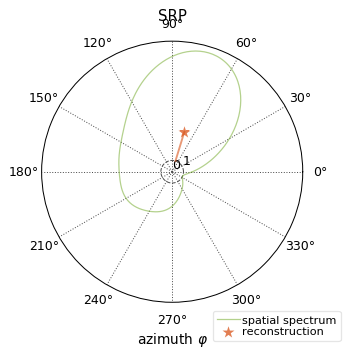

In [ ]:
'''
DOA Algorithms
==============

This example demonstrates how to use the DOA object to perform direction of arrival
finding in 2D using one of several algorithms

- MUSIC [1]_
- SRP-PHAT [2]_
- CSSM [3]_
- WAVES [4]_
- TOPS [5]_
- FRIDA [6]_

.. [1] R. Schmidt, *Multiple emitter location and parameter estimation*, 
    IEEE Trans. Antennas Propag., Vol. 34, Num. 3, pp 276--280, 1986

.. [2] J. H. DiBiase, J H, *A high-accuracy, low-latency technique for talker localization 
    in reverberant environments using microphone arrays*, PHD Thesis, Brown University, 2000

.. [3] H. Wang, M. Kaveh, *Coherent signal-subspace processing for the detection and 
    estimation of angles of arrival of multiple wide-band sources*, IEEE Trans. Acoust., 
    Speech, Signal Process., Vol. 33, Num. 4, pp 823--831, 1985

.. [4] E. D. di Claudio, R. Parisi, *WAVES: Weighted average of signal subspaces for 
    robust wideband direction finding*, IEEE Trans. Signal Process., Vol. 49, Num. 10, 
    2179--2191, 2001

.. [5] Y. Yeo-Sun, L. M. Kaplan, J. H. McClellan, *TOPS: New DOA estimator for wideband 
    signals*, IEEE Trans. Signal Process., Vol. 54, Num 6., pp 1977--1989, 2006

.. [6] H. Pan, R. Scheibler, E. Bezzam, I. Dokmanić, and M. Vetterli, *FRIDA:
    FRI-based DOA estimation for arbitrary array layouts*, Proc. ICASSP,
    pp 3186-3190, 2017

In this example, we generate some random signal for a source in the far field
and then simulate propagation using a fractional delay filter bank
corresponding to the relative microphone delays.

Then we perform DOA estimation and compare the errors for different algorithms

'''
from IPython.display import clear_output, Image, display, HTML
import IPython
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import audioop
import webrtcvad
import numpy as np
from scipy import stats
from scipy.io import wavfile
import csv

vad = webrtcvad.Vad()
vad.set_mode(1)

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

######
# We define a meaningful distance measure on the circle

# Location of original source
azimuth = 61. / 180. * np.pi  # 60 degrees
distance = 3.  # 3 meters

#######################
# algorithms parameters
SNR = 0.    # signal-to-noise ratio
c = 343.    # speed of sound
fs = 44100  # sampling frequency
nfft = 256  # FFT size
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation

# We use a circular array with radius 15 cm # and 12 microphones
R = pra.circular_2D_array((5,5), 6, 0., 0.0463)
source = np.array([2, 5])

fs, data = wavfile.read('audio.wav')

readings = np.zeros([5])
max_samples = 10
ti=int(fs/5)
time=0

writeFile= open('doa.csv', 'w')
writer = csv.writer(writeFile)
row=['frame','doa']
writer.writerow(row)

print('Audio file loaded')
print('Audio length:',data.shape[0]/fs,'seconds')
print('Number of blocks: ',data.shape[0] // ti)

for blocks in range(0,data.shape[0] // ti):
    signals=[]
    for i in range(0,data.shape[1]):
        signals.append(data[blocks*ti:(blocks+1)*ti,i])
    X = np.array([ 
        pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
        for signal in signals ])

    
    #algo_names = sorted(pra.doa.algorithms.keys())
    algo_name="SRP"
    #for algo_name in algo_names:
    #todetect=signals[0].copy(order='C')
    #todetect=audioop.ratecv(todetect,4,1,44100,16000, None)[0]
    #todetect=np.frombuffer(todetect, dtype=np.float32)
    #todetect=todetect.astype(np.int16)
    #vad.set_mode(3)
    #if vad.is_speech(todetect.tobytes(), 16000):
    
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)
    
    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)
    doa.polar_plt_dirac()
    plt.title(algo_name)
    
    # doa.azimuth_recon contains the reconstructed location of the source
        
    #reading = doa.azimuth_recon / np.pi * 180.
    #reading = int(round(reading[0]/90))
    #reading2 = int(round(reading2[0]/90))
    #if reading==4:
    #    reading=0
    #    readings = np.append(readings, reading)
    #    readings2 = np.append(readings2, reading)
    #    avg = stats.mode(readings)
    #    avg2 = stats.mode(readings2)
    #    readings = np.delete(readings, 0)
    #    readings2 = np.delete(readings2, 0)

    #print(blocks,blocks*ti/fs,algo_name,'  A1:', doa.azimuth_recon / np.pi * 180., ' A2:',doa2.azimuth_recon / np.pi * 180.," P1: ", int(avg[0][0]), ' P2:', int(avg2[0][0]) )
    #print('  Error:', circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180., 'degrees')
    clear_output(wait=True)
    plt.show()
    
    row=[blocks,doa.azimuth_recon / np.pi * 180.]
    writer.writerow(row)
    if blocks%100==0:
        print(blocks/(data.shape[0] // ti)*100,"%")
writeFile.close()



In [ ]:
from scipy.io import wavfile
import csv

fs, data = wavfile.read('audio.wav')

readings = np.zeros([5])
max_samples = 10
ti=int(fs/5)
time=0

writeFile= open('doa.csv', 'w')
writer = csv.writer(writeFile)
row=['frame','doa']
writer.writerow(row)

print('Audio file loaded')
print('Audio length:',data.shape[0]/fs,'seconds')
print('Number of blocks: ',data.shape[0] // ti)

for blocks in range(0,data.shape[0] // ti):
    signals=[]
    for i in range(0,data.shape[1]):
        signals.append(data[blocks*ti:(blocks+1)*ti,i])
    print(signals.shape)
    X = np.array([ 
        pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
        for signal in signals ])

    
    #algo_names = sorted(pra.doa.algorithms.keys())
    algo_name="SRP"
    #for algo_name in algo_names:
    #todetect=signals[0].copy(order='C')
    #todetect=audioop.ratecv(todetect,4,1,44100,16000, None)[0]
    #todetect=np.frombuffer(todetect, dtype=np.float32)
    #todetect=todetect.astype(np.int16)
    #vad.set_mode(3)
    #if vad.is_speech(todetect.tobytes(), 16000):
    
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)
    
    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)
    doa.polar_plt_dirac()
    plt.title(algo_name)
    
    # doa.azimuth_recon contains the reconstructed location of the source
        
    #reading = doa.azimuth_recon / np.pi * 180.
    #reading = int(round(reading[0]/90))
    #reading2 = int(round(reading2[0]/90))
    #if reading==4:
    #    reading=0
    #    readings = np.append(readings, reading)
    #    readings2 = np.append(readings2, reading)
    #    avg = stats.mode(readings)
    #    avg2 = stats.mode(readings2)
    #    readings = np.delete(readings, 0)
    #    readings2 = np.delete(readings2, 0)

    #print(blocks,blocks*ti/fs,algo_name,'  A1:', doa.azimuth_recon / np.pi * 180., ' A2:',doa2.azimuth_recon / np.pi * 180.," P1: ", int(avg[0][0]), ' P2:', int(avg2[0][0]) )
    #print('  Error:', circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180., 'degrees')
    #clear_output(wait=True)
    plt.show()
    
    row=[blocks,doa.azimuth_recon / np.pi * 180.]
    writer.writerow(row)
    if blocks%100==0:
        print(blocks/(data.shape[0] // ti)*100,"%")
writeFile.close()

In [2]:
data.shape[0] // 2000
tocv=signals[0].copy(order='C')
sig16=audioop.ratecv(tocv,4,1,44100,16000, None)[0]
siga=np.frombuffer(sig16, dtype=np.float32)
siga=siga.astype(np.int16)
print(webrtcvad.valid_rate_and_frame_length(16000, siga.shape[0]))
print(ti,siga.shape)
print(vad.is_speech(siga.tobytes(), 16000))

False
3200 (1161,)


Error: Error while processing frame

In [91]:
sample_rate = 16000
frame_duration = 10  # ms
frame = siga.tobytes()
print("Contains speech: %s" % (vad.is_speech(frame, sample_rate)))

Contains speech: True


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


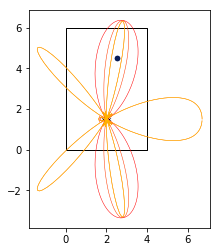

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

# Create a 4 by 6 metres shoe box room
room = pra.ShoeBox([4,6])

# Add a source somewhere in the room
room.add_source([2.5, 4.5])

# Create a linear array beamformer with 4 microphones
# with angle 0 degrees and inter mic distance 10 cm
R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
room.add_microphone_array(pra.Beamformer(R, room.fs))

# Now compute the delay and sum weights for the beamformer
room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# plot the room and resulting beamformer
room.plot(freq=[1000, 2000, 4000, 8000], img_order=0)
plt.show()

In [176]:
from scipy.io import wavfile
fs, data = wavfile.read('./recordings/audio6.wav')
print(data.shape)
readings = np.zeros([5])
max_samples = 10
################################
# Compute the STFT frames needed
ti=int(fs*10)
signals=[]
for i in range(0,data.shape[1]):
    signals.append(data[0:ti,i])

room_bf = pra.ShoeBox([10,10], fs=44100)
source = np.array([4.5, 5])
room_bf.add_source(source, delay=0.)

bf=pra.Beamformer(R, fs)
bf.signals=signals
#bf.rake_delay_and_sum_weights(room_bf.sources[0][:1])
bf.rake_delay_and_sum_weights(room_bf.sources[0][:1])
room_bf.add_microphone_array(bf)
filtered=bf.process(FD=False)
IPython.display.Audio(signals[0], rate=fs)
#IPython.display.Audio(filtered, rate=fs)

(5292000, 6)


In [177]:
IPython.display.Audio(filtered, rate=fs)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


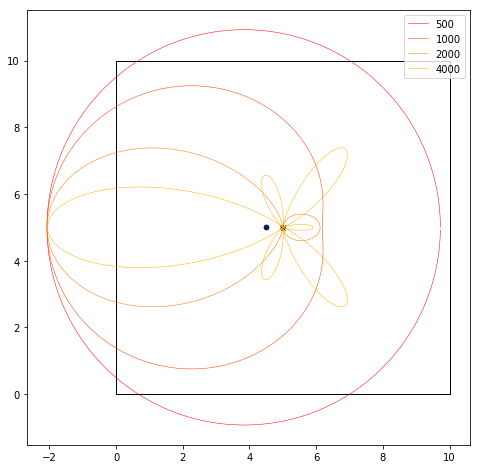

In [178]:
fig, ax = room_bf.plot(freq=[500, 1000, 2000, 4000], img_order=0)
ax.legend(['500', '1000', '2000', '4000'])
fig.set_size_inches(20, 8)

In [4]:
2+3

5